# Image processor

## Imports

In [2]:
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from math import sqrt, ceil
from skimage.transform import resize
from skimage import io, color
import pandas as pd
import cv2
import matplotlib.patches as patches
import json
import random
from skimage import exposure

## Model saver

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading data from disk

In [ ]:
dataPath = "./data/signs/"
imagesPath = dataPath + "images/"
metaDataPath = dataPath + "signs.json"

In [ ]:
def openImage(path):
    img = io.imread(path)
    return img.astype(np.uint8)

def loadImagesFromFolder(path):
    folder = listdir(path)
    images = []
    imageNames = []
    for imgPath in folder:
        img = openImage(path + imgPath)
        images.append(img)
        imageNames.append(imgPath)
    return np.asarray(images), np.array(imageNames)

def loadMetadata(path):
    with open(path) as metadata:
        return json.load(metadata)

In [ ]:
images, imageNames = loadImagesFromFolder(imagesPath)

In [ ]:
data = loadMetadata(metaDataPath)

## Process images

### Arrange data

In [ ]:
def sortSigns(images, names, data):
    signs = []
    for i in range(0, len(images)):
        name = names[i]
        imageData = [ d for d in data if d['name'] == name ][0]
        normalizeImageSigns(imageData['signs'], 
                                    images[i].shape[1], images[i].shape[0],
                                   imageData['w'], imageData['h'])
        signs.append(imageData['signs'])
    return np.array(signs)
    
def filterEmptyImages(imgs, names, data):
    imgFilter = [ len(signs) > 0 for signs in data ]
    return imgs[imgFilter], names[imgFilter], data[imgFilter]
    
def normalizeImageSigns(signs, w1, h1, w2, h2):
    constx, consty = w1 / w2, h1 / h2
    for sign in signs:
        sign['x'] = sign['x'] * constx + 5
        sign['y'] = sign['y'] * consty + 5
        sign['w'] = sign['w'] * constx + 10
        sign['h'] = sign['h'] * consty + 10
    
def getBoundariesForImage(image, signs):
    ax, ay = signs[0]['x'], signs[0]['y']
    bx, by = signs[0]['x'], signs[0]['y']
    
    for sign in signs:
        if sign['x'] - sign['w'] / 2.0 < ax:
            ax = sign['x'] - sign['w'] / 2
        if sign['y'] - sign['h'] / 2.0 < ay:
            ay = sign['y'] - sign['h'] / 2.0
        if sign['x'] + sign['w'] / 2.0 > bx:
            bx = sign['x'] + sign['w'] / 2.0
        if sign['y'] + sign['h'] / 2.0 > by:
            by = sign['y'] + sign['h'] / 2.0
    return (ax, ay), (bx, by)

def getBoundaries(images, signs):
    boundaries = []
    for i in range(0, len(images)):
        boundaries.append(getBoundariesForImage(images[i], signs[i]))
    return boundaries

In [ ]:
signs = sortSigns(images, imageNames, data)

In [ ]:
images, imageNames, signs = filterEmptyImages(images, imageNames, signs)

In [ ]:
boundaries = getBoundaries(images, signs)

### Sanity check

In [7]:
def showImageWithSigns(image, sgns):   
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    for sign in sgns:
        x, y = sign['x'] - sign['w'] / 2, sign['y'] - sign['h'] / 2
        w, h = sign['w'], sign['h']
        rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [ ]:
showImageWithSigns(images[0], signs[0])

### Crop images

In [ ]:
def cropImages(images, boundaries, signs):
    croppedImages = []
    newBoundaries = []
    newSigns = []
    for i in range(0, len(images)):
        (ax, ay), (bx, by) = getDimensions(images[i], boundaries[i])
        image = cropImage(images[i], ax, ay, bx, by)
        croppedImages.append(image)
        b = boundaries[i]
        newBoundaries.append((
            (b[0][0] - ax, b[0][1] - ay), 
            (b[1][0] - ax, b[1][1] - ay)
        ))
        s = signs[i]
        newSigns.append([ {
            'x': sign['x'] - ax,
            'y': sign['y'] - ay,
            'w': sign['w'],
            'h': sign['h']
        } for sign in s ])
    return croppedImages, newBoundaries, newSigns
        
def cropImage(img, ax, ay, bx, by):
    return img[ay:by, ax:bx]

def transformBoundariesAndSigns(boundaries, signs, dx, dy):
    boundaries[0][0] += dx
    boundaries[0][1] += dy
    boundaries[1][0] += dx
    boundaries[1][1] += dy
    for sign in signs:
        sign['x'] += dx
        sign['y'] += dy

def getDimensions(image, boundaries, scaleFactor=4):
    (ax, ay), (bx, by) = boundaries
    w, h = bx - ax, by - ay
    size = max(w, h) * scaleFactor
    x, y = ax + w / 2, ay + h / 2
    
    (ax, ay) = x - size / 2, y - size / 2
    (bx, by) = x + size / 2, y + size / 2
    return (int(ax), int(ay)), (int(bx), int(by))

In [ ]:
images, boundaries, signs = cropImages(images, boundaries, signs)

In [ ]:
def filterEmptyImages(images, b, s):
    notEmpty = [ i.shape[0] != 0 and i.shape[1] != 0 for i in images ]
    return np.array(images)[notEmpty], np.array(b)[notEmpty], np.array(s)[notEmpty]

In [ ]:
images, boundaries, signs = filterEmptyImages(images, boundaries, signs)

### Resize images

In [13]:
def resizeImage(image, boundaries, signs, w, h):
    scale = float(w) / image.shape[0]
    image = resize(image, (w, h))
    boundaries = scaleBoundaries(boundaries, scale)
    signs = scaleSigns(signs, scale)
    return np.array(image), boundaries, signs
    
def scaleSigns(signs, scale):
    return [ {
            'x': sign['x'] * scale,
            'y': sign['y'] * scale,
            'w': sign['w'] * scale,
            'h': sign['h'] * scale
        } for sign in signs ]

def scaleBoundaries(boundaries, scale):
    b = boundaries
    return (b[0][0] * scale, b[0][1] * scale), (b[1][0] * scale, b[1][1] * scale)

def resizeImages(images, boundaries, signs, w, h):
    for i in range(0, len(images)):
        images[i], boundaries[i], signs[i] = resizeImage(images[i], boundaries[i], signs[i], w, h)

In [ ]:
resizeImages(images, boundaries, signs, 400, 400)

In [ ]:
showImageWithSigns(images[30], signs[30])

In [ ]:
def showAllImages(images, signs):
    for i in range(0, len(images)):
        print(i)
        showImageWithSigns(images[i], signs[i])
showAllImages(images, signs)

In [ ]:
blackList = [12, 36, 47, 51, 69, 78, 83, 98, 101, 118, 120, 130]

In [ ]:
def deleteBlackList(blackList, images, boundaries, signs):
    images = np.delete(images, blackList)
    boundaries = np.delete(np.array(boundaries), blackList, 0)
    signs = np.delete(signs, blackList)
    return images, boundaries, signs

In [ ]:
images, boundaries, signs = deleteBlackList(blackList, images, boundaries, signs)

### Save resized images

In [5]:
path = 'data/signs'

In [ ]:
ModelSaver(path).save({
    'images': images,
    'boundaries': boundaries,
    'signs': signs
})

In [4]:
data = ModelSaver(path).load()

In [5]:
images, boundaries, signs = np.array(data['images']), np.array(data['boundaries']), data['signs']

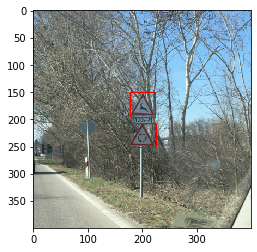

In [8]:
showImageWithSigns(images[12], signs[12])

## Generate training data

### Random transformations

In [9]:
def cropImage(image, boundaries, signs, ax, ay, bx, by):
    image = image[ay:by, ax:bx]
    
    b = boundaries
    boundaries = ((b[0][0] - ax, b[0][1] - ay), (b[1][0] - ax, b[1][0] - ay))
    newSigns = [{
        'x': sign['x'] - ax, 
        'y': sign['y'] - ay, 
        'w': sign['w'], 
        'h': sign['h']
    } for sign in signs]
    
    return image, boundaries, newSigns

def getRandomTransformation(w, h, ax, ay, bx, by):
    ax2, ay2 = random.randint(1, ax), random.randint(1, ay)
    min_w = max(bx - ax2, by - ay2)
    max_w = min(w - ax2, h - ay2)
    if (min_w - max_w > 0):
        return getRandomTransformation(w, h, ax, ay, bx, by)
    w2 = random.randint(min_w, max_w)
    bx2, by2 = ax2 + w2, ay2 + w2
    return ax2, ay2, bx2, by2

def changeBrightness(image, value):
    hsv = cv2.cvtColor(image.astype('float32'), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)

def getRandomlyTransformedImage(image, boundaries, signs):
    w, h = image.shape[1], image.shape[0]
    (ax, ay), (bx, by) = boundaries
    ax2, ay2, bx2, by2 = getRandomTransformation(w, h, int(ax), int(ay), int(bx), int(by))
    image, boundaries, signs = cropImage(image, boundaries, signs, ax2, ay2, bx2, by2)
    image = changeBrightness(image, random.randint(-100, 100) / 250.0)
    return image, boundaries, signs

def getNRandomImage(image, boundaries, signs, n):
    output = []
    for i in range(0, n):
        output.append(getRandomlyTransformedImage(image, boundaries, signs))
    output = np.array(output)
    resizeImages(output[:, 0], output[:, 1], output[:, 2], 100, 100)
    return output

In [ ]:
def test():
    image, b, s = getNRandomImage(images[4], boundaries[4], signs[4], 2)[0]
    showImageWithSigns(image, s)

In [ ]:
showImageWithSigns(images[68], signs[68])

### Train and test set

In [10]:
def splitData(images, boundaries, signs, testRatio):
    size = len(images)
    
    mask = np.random.random_sample(size) > testRatio
    training = (images[mask], boundaries[mask], signs[mask])
    testing = (images[~mask], boundaries[~mask], signs[~mask])
    
    return training, testing

def multiplyData(data, n):
    images, boundaries, signs = data
    newImages, newSigns = [], []
    for i in range(0, len(images)):
        output = getNRandomImage(images[i], boundaries[i], signs[i], n)
        for image, _, nsigns in output:
            newImages.append(image)
            newSigns.append(nsigns)
    return newImages, newSigns

In [11]:
train, test = splitData(images, boundaries, signs, 0.2)

In [14]:
train = multiplyData(train, 40)

In [15]:
test = multiplyData(test, 40)

### Save images again

In [16]:
ModelSaver(path + '/train-test-multiplied').save({
    'train': train,
    'test': test
})

### Generate grid

In [25]:
def generateY(allSigns, n):
    y = []
    for signs in allSigns:
        y.append(generateGrid(signs, n))
    return np.array(y)
    
def generateGrid(signs, n):
    gridSize = 100 / n
    emptyGrid = np.full(5, 0)
    grid = np.full((n, n, 5), emptyGrid).astype('float32')
    
    for sign in signs:
        i, j, y = signInGridCoorinates(sign, n)
        grid[i, j] = np.array(y)
    return grid

def getGridCorner(i, j, n):
    return 100.0 / n * i, 100.0 / n * j

def signInGridCoorinates(sign, n):
    gridSize = 100.0 / n
    i = int(sign['x'] / gridSize)
    j = int(sign['y'] / gridSize)
    ax, ay = getGridCorner(i, j, n)
    y = (1, (sign['x'] - ax) / gridSize, (sign['y'] - ay) / gridSize, sign['w'] / gridSize, sign['h'] / gridSize)
    return i, j, y

def shuffle(x, y):
    permutation = np.random.permutation(x.shape[0])
    x = np.take(x, permutation, axis=0)
    y = np.take(y, permutation, axis=0)
    return x, y

In [18]:
xTrain = np.array(train[0])
yTrain = generateY(train[1], 15)
xTest = np.array(test[0])
yTest = generateY(test[1], 15)

In [19]:
xTrain, yTrain = shuffle(xTrain, yTrain)
xTest, yTest = shuffle(xTest, yTest)

## Normalize images

In [20]:
def histogramEqualization(img):
    imgEq = exposure.equalize_hist(img)
    return imgEq

def meanNorm(imgs):
    print('Mean norm...')
    means = np.mean(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(means)):
        normalized[i] -= means[i]
    return normalized

def stdNorm(imgs):
    print('Std norm...')
    stds = np.std(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(stds)):
        normalized[i] /= stds[i]
    return normalized

def minMaxNorm(imgs):
    print('Min-Max norm...')
    low = np.min(imgs, axis=(1, 2, 3))
    high = np.max(imgs, axis=(1, 2, 3))
    normalized = np.array([img for img in imgs])
    for i in range(0, len(imgs)):
        normalized[i] = (normalized[i] - low[i]) / (high[i] - low[i])
    return normalized * 2 - 1

def applyNormalization(imgs):
    imgs = imgs.astype(np.float32)
    imgs = meanNorm(imgs)
    imgs = stdNorm(imgs)
    imgs = minMaxNorm(imgs)
    return imgs

def preprocess(x, y):
    print('Histogram equalization...')
    x = histogramEqualization(x)
    x = applyNormalization(x)
    y = [ i for i in y ]
    shuffle(x, y)
    print('Done')
    return np.array(x), np.array(y)

In [21]:
xTrain, yTrain = preprocess(xTrain, yTrain)
xTest, yTest = preprocess(xTest, yTest)

Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Done
Histogram equalization...
Mean norm...
Std norm...
Min-Max norm...
Done


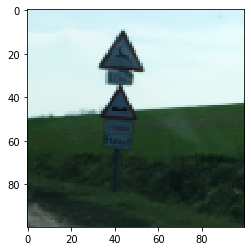

In [52]:
def showImage(img):
    low, high = np.min(img), np.max(img)
    img = (img - low) / (high - low)
    plt.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    plt.show()

showImage(xTest[13])

## Save

In [24]:
ModelSaver(path + '/train-test-normalized').save({
    'xTrain': xTrain,
    'yTrain': yTrain,
    'xTest': xTest,
    'yTest': yTest
})

In [6]:
data = ModelSaver(path + '/train-test-normalized').load()
xTrain = data['xTrain']
yTrain = data['yTrain']
xTest = data['xTest']
yTest = data['yTest']

In [16]:
def correctY(y):
    for img in y:
        for i in range(0, 15):
            for j in range(0, 15):
                img[i][j][1], img[i][j][2] = img[i][j][1] / (100.0 / 15), img[i][j][2] / (100.0 / 15)

In [35]:
def iou (a, b):
    ax1, ax2, ay1, ay2 = a[0] - a[2] / 2, a[0] + a[2] / 2, a[1] - a[3] / 2, a[1] + a[3] / 2
    bx1, bx2, by1, by2 = b[0] - b[2] / 2, b[0] + b[2] / 2, b[1] - b[3] / 2, b[1] + b[3] / 2
    x1, x2 = max(ax1, bx1), min(ax2, bx2)
    y1, y2 = max(ay1, by1), min(ay2, by2)
    print(bx1, bx2, by1, by2)
    intersection = (x2 - x1) * (y2 - y1)
    union = a[2] * a[3] + b[2] * b[3] - intersection
    print(intersection, union)
    return intersection / union

In [22]:
def showImageWithGrid(x, grid): 
    low, high = np.min(x), np.max(x)
    img = (x - low) / (high - low)
    fig,ax = plt.subplots(1)
    fig.set_size_inches(10, 10)
    ax.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    
    gridSize = 100.0 / 15
    
    ax.vlines([ gridSize * i for i in range(1, 15)], 0, 99  )
    ax.hlines([ gridSize * i for i in range(1, 15)], 0, 99  )
    
    for i in range(0, 15):
        for j in range(0, 15):
            if (grid[i][j][0] == 1):
                sign = grid[i][j]
                print(sign[3])
                w, h = sign[3] * gridSize, sign[4] * gridSize
                x, y = i * gridSize + sign[1] * gridSize - w / 2, j * gridSize + sign[2] * gridSize - h / 2
                rect = patches.Rectangle((x, y), w, h,
                                         linewidth=1,edgecolor='r',facecolor='none')
                rect.set_zorder(10)
                ax.add_patch(rect)
    
    plt.show()

In [26]:
arr = [1, 2, 3, 4]

In [27]:
arr[1:2]

[2]